In [1]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Download latest version
# === Download Dataset ===
# Fetch the dataset
dataset = fetch_ucirepo(id=697)
X = dataset.data.features
y = dataset.data.targets
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

print(X.columns.tolist())


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Features shape: (4424, 36), Target shape: (4424, 1)
['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rat

In [4]:
# Simple preprocessing: encode targets and split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# After your split...
total = X.shape[0]
train_pct = X_train.shape[0] / total * 100
test_pct  = X_test.shape[0]  / total * 100

print(f"Train: {X_train.shape} ({train_pct:.1f}%), Test: {X_test.shape} ({test_pct:.1f}%)")


Train: (3539, 36), Test: (885, 36)
Train: (3539, 36) (80.0%), Test: (885, 36) (20.0%)


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# Train Random Forest classifier with class weighting
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [6]:
# Evaluate on test set
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.76      0.79       284
    Enrolled       0.59      0.35      0.44       159
    Graduate       0.79      0.94      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.68      0.70       885
weighted avg       0.76      0.78      0.76       885

Confusion Matrix:
[[216  23  45]
 [ 38  56  65]
 [ 10  16 416]]


In [ ]:
import contextlib
import optuna.logging as logging

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 0) Set Optuna logging
logging.set_verbosity(logging.INFO)

# 1) Prepare data
# Replace the next two lines with your actual X, y loading
# Example:
# from ucimlrepo import fetch_ucirepo
# ds = fetch_ucirepo(id=697)
# X_raw, y_raw = ds.data.features, ds.data.targets

# For now assume X and y already in scope:
y = LabelEncoder().fit_transform(y)
X_scaled = StandardScaler().fit_transform(X)

# 2) Define objectives

def objective_lgbm(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 15, 100)
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_scaled, y, cv=3, scoring='f1_macro').mean()
    trial.report(score, step=0)
    return score

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **params)
    score = cross_val_score(model, X_scaled, y, cv=3, scoring='f1_macro').mean()
    trial.report(score, step=0)
    return score

# 3) Create studies
study_lgbm = optuna.create_study(direction='maximize')
study_xgb  = optuna.create_study(direction='maximize')

# 4) Run tuning with logs redirected to disk
with open('lgbm_optuna.log', 'w') as log_f:
    with contextlib.redirect_stdout(log_f), contextlib.redirect_stderr(log_f):
        study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

with open('xgb_optuna.log', 'w') as log_f:
    with contextlib.redirect_stdout(log_f), contextlib.redirect_stderr(log_f):
        study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

# 5) Save concise summary
with open('optuna_summary.txt', 'w') as summary:
    summary.write("=== LightGBM Tuning Results ===\n")
    summary.write(f"Best f1_macro:  {study_lgbm.best_value:.6f}\n")
    summary.write(f"Best hyperparams: {study_lgbm.best_params}\n\n")
    summary.write("=== XGBoost Tuning Results ===\n")
    summary.write(f"Best f1_macro:  {study_xgb.best_value:.6f}\n")
    summary.write(f"Best hyperparams: {study_xgb.best_params}\n")

# 6) Display only the summary in the notebook
print(open('optuna_summary.txt').read())

# 7) Instantiate best models for downstream use
best_lgbm = LGBMClassifier(**study_lgbm.best_params)
best_xgb  = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **study_xgb.best_params)
best_cat  = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.05, verbose=0)

# Optional: show top 5 LightGBM trials as a sanity check
print("\nLightGBM top trials:")
print(study_lgbm.trials_dataframe().sort_values("value", ascending=False).head())


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-04-27 15:15:53,742] A new study created in memory with name: no-name-86d96a60-859d-46b6-896f-a4b44b5498cb
[I 2025-04-27 15:15:53,742] A new study created in memory with name: no-name-fc24dad5-02c5-427f-92fe-719bff53557a


=== LightGBM Tuning Results ===
Best f1_macro:  0.710595
Best hyperparams: {'max_depth': 3, 'learning_rate': 0.010567483804661023, 'n_estimators': 1232, 'reg_alpha': 1.5938542639816995, 'reg_lambda': 1.7485295929473148, 'subsample': 0.8842541299566447, 'colsample_bytree': 0.8132117272672919, 'num_leaves': 81}

=== XGBoost Tuning Results ===
Best f1_macro:  0.710930
Best hyperparams: {'max_depth': 12, 'learning_rate': 0.09791118067683054, 'n_estimators': 616, 'gamma': 2.0413885170867463, 'min_child_weight': 5, 'subsample': 0.7142788461661153, 'colsample_bytree': 0.9340193806317157}


LightGBM top trials:
    number     value             datetime_start          datetime_complete  \
0        0  0.710595 2025-04-27 15:15:53.744862 2025-04-27 15:15:56.056380   
8        8  0.709507 2025-04-27 15:16:13.619849 2025-04-27 15:16:16.004547   
21      21  0.709343 2025-04-27 15:16:48.470844 2025-04-27 15:16:52.212465   
22      22  0.708399 2025-04-27 15:16:52.213463 2025-04-27 15:16:58.568334   

In [8]:
# === StratifiedKFold CV with Voting Ensemble ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    ensemble = VotingClassifier(
        estimators=[
            ('lgbm', best_lgbm),
            ('xgb', best_xgb),
            ('cat', best_cat)
        ],
        voting='soft'
    )
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_val)
    all_preds.extend(preds)
    all_true.extend(y_val)
    print(f"Fold {fold+1} Accuracy: {accuracy_score(y_val, preds):.4f}")

# === Final Evaluation ===
print("\n=== Overall Performance ===")
print(classification_report(all_true, all_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] Start training from score -1.136331
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.693995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:18:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 Accuracy: 0.7853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] Start training from score -1.135451
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.694561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:18:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 Accuracy: 0.7751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] Start training from score -1.135451
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.694561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:18:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 Accuracy: 0.7808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] Start training from score -1.135451
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.694561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:18:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 Accuracy: 0.7774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 3540, number of used features: 36
[LightGBM] [Info] Start training from score -1.135734
[LightGBM] [Info] Start training from score -1.716683
[LightGBM] [Info] Start training from score -0.694844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:18:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 Accuracy: 0.7794

=== Overall Performance ===
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1421
           1       0.58      0.40      0.47       794
           2       0.80      0.93      0.86      2209

    accuracy                           0.78      4424
   macro avg       0.73      0.70      0.71      4424
weighted avg       0.77      0.78      0.77      4424



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


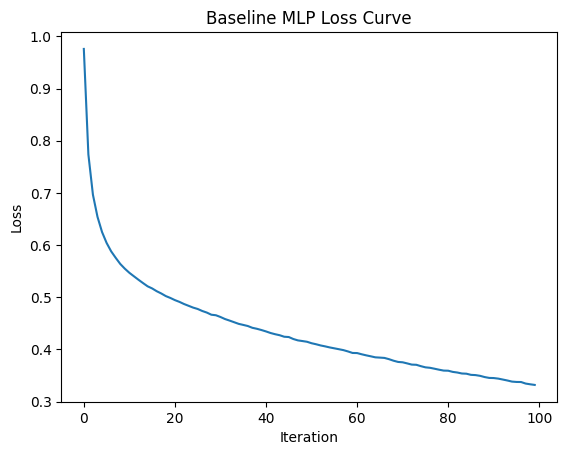

In [9]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# 1) Train a simple MLP
mlp = MLPClassifier(random_state=42, max_iter=100, verbose=False)
mlp.fit(X_train, y_train)

# 2) Plot the loss over iterations
plt.figure()
plt.plot(mlp.loss_curve_)
plt.title("Baseline MLP Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_c

Baseline MLP Test Accuracy: 0.320

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.32      1.00      0.49       284
    Enrolled       0.00      0.00      0.00       159
    Graduate       0.00      0.00      0.00       442

    accuracy                           0.32       885
   macro avg       0.11      0.33      0.16       885
weighted avg       0.10      0.32      0.16       885



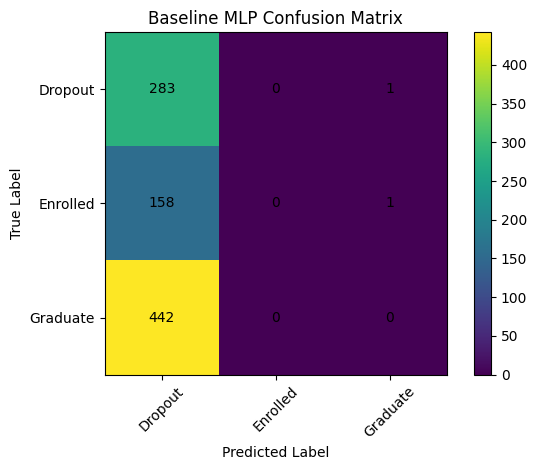

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1) Predict on test set
y_pred = mlp.predict(X_test)

# 2) Compute metrics
acc = accuracy_score(y_test, y_pred)
print(f"Baseline MLP Test Accuracy: {acc:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 3) Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Baseline MLP Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.colorbar()

# 4) Tick labels
labels = le.classes_
ticks = np.arange(len(labels))
plt.xticks(ticks, labels, rotation=45)
plt.yticks(ticks, labels)

# 5) Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()
